# DP-SurfaceDetection - Training run


In [2]:
# import system packages
import os
import json
import glob
import numpy as np
import random as rand
#import librosa
#import librosa.display
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

# import pytorch stuff
import torch
import torch.nn as nn
from torch.utils import data
import torchvision.transforms as T
from torch.utils.data import *

# import own python files
%load_ext autoreload
%autoreload 2
#from train import *



The autoreload extension is already loaded. To reload it, use:
  %reload_extautoreload


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
device = "cpu"
print("Using device:", device)


Using device:cuda


In [4]:
# FCN with Resnet-101 backbone
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt
import torch


def decode_segmap(image, nc=21):
  
    label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb

def segment(net, path, show_orig=True, dev='cuda'):
    img = Image.open(path)
    if show_orig: plt.imshow(img); plt.axis('off'); plt.show()
    # Comment the Resize and CenterCrop for better inference results
    trf = T.Compose([T.Resize(640), 
                   #T.CenterCrop(224), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
    inp = trf(img).unsqueeze(0).to(dev)
    out = net.to(dev)(inp)['out']
    om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
    print (om.shape)
    print (np.unique(om))
    rgb = decode_segmap(om)
    plt.imshow(rgb); plt.axis('off'); plt.show()


In [14]:
pwd = os.path.join(os.getcwd(), "example_data")
print("current working directory:\t", pwd)

current working directory:c:\Users\lukas\workspace\DP-SurfaceDetection\example_data


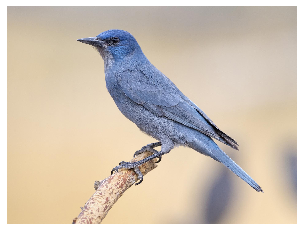

RuntimeError: CUDA out of memory. Tried to allocate 34.00 MiB (GPU 0; 1024.00 MiB total capacity; 442.93 MiB already allocated; 12.17 MiB free; 33.07 MiB cached)

In [15]:
fcn = models.segmentation.fcn_resnet101(pretrained=True).eval()
# segment(fcn, '../bird.jpg', dev=device)
segment(fcn, os.path.join(pwd, 'bird.jpg'), dev=device)

In [0]:

dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()
segment(dlab, '../horse.jpg', dev=device)

In [0]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# old stuff below -----

In [0]:
from functools import reduce

class NSynthDataset(data.Dataset):
    def __init__(self, root, transform=None, target_transform=None, domains=['']):
        self.root = root
        self.transform=transform
        self.target_transform = None
        self.domains = domains
        self.filenames = reduce((lambda a, b: a + b), 
                                map(lambda domain: glob.glob(os.path.join(root, "audio/" + domain  + "*.wav")), domains))
        with open(os.path.join(root, "examples.json"), "r") as f:
            self.json_data = json.load(f)
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, i):
        sample = self.get_spectrogram(i)
        target = self.get_target(i)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)
        augmented_sample = sample
        return sample, augmented_sample, target
    
    def get_spectrogram(self, i, n_mels=128, sr=16000, fmax=8000):
        y, _ = librosa.load(self.get_name(i), sr=sr)
        return librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
    
    def get_name(self, i):
        return self.filenames[i]
    
    def get_target_str(self, i):
        data = self.json_data[os.path.splitext(os.path.basename(self.get_name(i)))[0]]
        return data['instrument_family_str'] + '_' + data['instrument_source_str']

    def get_target_str_full(self, i):
        data = self.json_data[os.path.splitext(os.path.basename(self.get_name(i)))[0]]
        return data['instrument_str']
    
    def get_target(self, i):
        target = self.get_target_str(i)
        if target in self.domains:
            return self.domains.index(target)
        else:
            return -1

In [0]:
def plot_spectrogram(S, title=None, sr=16000, fmax=8000):
    plt.figure(figsize=(10, 4))
    S_dB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=fmax)
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.title(title)
    plt.show()

In [0]:
transform = T.Compose([
                T.ToTensor(), 
                nn.ConstantPad2d((0, 2), 0), # To get the size to be 128x128
                T.Normalize((5.598382777731995,), (71.13882950507647,), inplace=True) 
])

dataset = NSynthDataset(root='nsynth-test', transform=transform)

%matplotlib inline
print(dataset.get_name(6))
#plot_spectrogram(dataset.get_spectrogram(6), title=dataset.get_name(6))

In [0]:
val_ratio = 0.15
test_ratio = 0.1

domains = ['flute_synthetic','bass_synthetic'] #flute_synthetic
dataset = NSynthDataset(root='nsynth-test', transform=transform, domains=domains)

test_number = rand.randrange (0,len(dataset[0]),1)
# test_number = 315

plot_spectrogram(dataset.get_spectrogram(test_number), title=dataset.get_target_str_full(test_number))
n_samples = len(dataset)
n_val_samples = int(n_samples*val_ratio)
n_test_samples = int(n_samples*test_ratio)
n_train_samples = n_samples-n_val_samples-n_test_samples

train_dataset, val_dataset, test_dataset = random_split(dataset, [n_train_samples, n_val_samples, n_test_samples])

print("Total number of samples: {}".format(len(dataset)))
print("Number of training samples: {}".format(len(train_dataset)))
print("Number of validation samples: {}".format(len(val_dataset)))
print("Number of testing samples: {}".format(len(test_dataset)))

In [0]:
def create_dataset(domain, root='nsynth-test'):
    dataset = NSynthDataset(root=root, transform=transform, domains=domain)
    print("Total number of samples in dataset for domain \"{}\": {}".format(domain, len(dataset)))
    return dataset

def create_loaders_for_domain(domain, root='nsynth-test',bs=16):
    
    dataset = NSynthDataset(root=root, transform=transform, domains=domain)

    test_number = rand.randrange (0,len(dataset),1)
    #plot_spectrogram(dataset.get_spectrogram(test_number), title=dataset.get_target_str(test_number))
    
    val_ratio = 0.15
    test_ratio = 0.1
    n_samples = len(dataset)
    n_val_samples = int(n_samples*val_ratio)
    n_test_samples = int(n_samples*test_ratio)
    n_train_samples = n_samples-n_val_samples-n_test_samples

    train_dataset, val_dataset, test_dataset = random_split(dataset, [n_train_samples, n_val_samples, n_test_samples])

    print("Total number of samples: {}".format(len(dataset)))
    print("Number of training samples: {}".format(len(train_dataset)))
    print("Number of validation samples: {}".format(len(val_dataset)))
    print("Number of testing samples: {}".format(len(test_dataset)))
    
    print("Creating data loaders for {}...".format(domain), end="\r")
    train_loader = DataLoader(train_dataset, batch_sampler=MusicBatchSampler(data_source=train_dataset,batch_size=bs))
    val_loader = DataLoader(val_dataset, batch_sampler=MusicBatchSampler(data_source=val_dataset,batch_size=bs))
    test_loader = DataLoader(val_dataset, batch_sampler=MusicBatchSampler(data_source=test_dataset,batch_size=len(test_dataset)))
    print("Creating data loaders ... [Done]")
    
    return train_loader, val_loader, test_loader
    